In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
import datetime
%matplotlib inline 

In [2]:
confirmed = pd.read_csv('/Users/Zhang/Desktop/jupyter/ncov/time_series_covid_19_confirmed.csv')
death = pd.read_csv('time_series_covid_19_deaths.csv')
recovered = pd.read_csv('time_series_covid_19_recovered.csv')

In [3]:
confirmed = confirmed.loc[confirmed['Province/State'] == 'Hubei']
death = death.loc[death['Province/State'] == 'Hubei']
recovered = recovered.loc[recovered['Province/State'] == 'Hubei']

In [4]:
death = death.replace(to_replace ="Hubei",value ="death") 
confirmed = confirmed.replace(to_replace ="Hubei",value ="confirmed") 
recovered = recovered.replace(to_replace ="Hubei",value ="recovered") 

In [5]:
dataset = pd.concat([confirmed,death,recovered])

In [6]:
dataset = dataset.drop(columns=['Country/Region', 'Lat','Long'])

In [7]:
dataset = dataset.rename(columns={'Province/State': 'type'})

In [8]:
dataset.head()

,type,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20
12,confirmed,444,444,549,761,1058,1423,3554,3554,4903,...,64084.0,64084.0,64287.0,64786.0,65187.0,65596.0,65914.0,66337.0,66907.0,67103.0
12,death,17,17,24,40,52,76,125,125,162,...,2346.0,2346.0,2495.0,2563.0,2615.0,2641.0,2682.0,2727.0,2761.0,2803.0
12,recovered,28,28,31,32,42,45,80,88,90,...,15299.0,15343.0,16748.0,18971.0,20969.0,23383.0,26403.0,28993.0,31536.0,33934.0


In [9]:
dates = dataset.keys()
dates = dates.drop("type")
print(dates)

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20',
       '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', '2/9/20',
       '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', '2/15/20',
       '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20', '2/21/20',
       '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', '2/27/20',
       '2/28/20', '2/29/20', '3/1/20', '3/2/20'],
      dtype='object')


In [10]:
tc = []
td = [] 
tr = []
for i in range(dates.size):
    tc.append(int(dataset.iloc[0,i+1]))
    td.append(int(dataset.iloc[1,i+1]))
    tr.append(int(dataset.iloc[2,i+1]))
tc = np.asarray(tc)

In [11]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)

In [12]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)

In [13]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))
adjusted_dates = future_forcast_dates[:-10]
print(future_forcast_dates)

['01/22/2020', '01/23/2020', '01/24/2020', '01/25/2020', '01/26/2020', '01/27/2020', '01/28/2020', '01/29/2020', '01/30/2020', '01/31/2020', '02/01/2020', '02/02/2020', '02/03/2020', '02/04/2020', '02/05/2020', '02/06/2020', '02/07/2020', '02/08/2020', '02/09/2020', '02/10/2020', '02/11/2020', '02/12/2020', '02/13/2020', '02/14/2020', '02/15/2020', '02/16/2020', '02/17/2020', '02/18/2020', '02/19/2020', '02/20/2020', '02/21/2020', '02/22/2020', '02/23/2020', '02/24/2020', '02/25/2020', '02/26/2020', '02/27/2020', '02/28/2020', '02/29/2020', '03/01/2020', '03/02/2020', '03/03/2020', '03/04/2020', '03/05/2020', '03/06/2020', '03/07/2020', '03/08/2020', '03/09/2020', '03/10/2020', '03/11/2020', '03/12/2020']


In [14]:
from sklearn.model_selection import TimeSeriesSplit

In [15]:
tscv = TimeSeriesSplit()

/Users/Zhang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:784: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


In [16]:
for train_index, test_index in tscv.split(days_since_1_22):
    X_train_confirmed, X_test_confirmed = days_since_1_22[train_index], days_since_1_22[test_index]
    y_train_confirmed, y_test_confirmed = tc[train_index], tc[test_index]

In [17]:
#X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, tc, test_size=0.1, shuffle=False) 
#print(X_test_confirmed)

In [18]:
#random forest

In [19]:
ensemble_grid =  {'n_estimators': [(i+1)*10 for i in range(20)],
                 'criterion': ['mse', 'mae'],
                 'bootstrap': [True, False],
                 
                 }

ensemble = RandomForestRegressor()
ensemble_search = RandomizedSearchCV(ensemble, ensemble_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
ensemble_search.fit(X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.2s finished
/Users/Zhang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_state=N

In [20]:
ensemble_search.best_params_
ensemble_confirmed = ensemble_search.best_estimator_
ensemble_pred = ensemble_confirmed.predict(future_forcast)

In [21]:
# Knn

In [22]:
# knn_grid = {'n_neighbors': range(1, 10)}
# knn = KNeighborsRegressor()
# knn_search = RandomizedSearchCV(knn, knn_grid,scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
# knn_search.fit(X_train_confirmed, y_train_confirmed)

In [23]:
#knn_search.best_params_
#knn_confirmed = knn_search.best_estimator_
#knn_pred = knn_confirmed.predict(future_forcast)
# since knn and random forest has the same prediction results, just ignore.

In [24]:
#Bayesian Ridge

In [25]:
BayesianRidge_search = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)
BayesianRidge_search.fit(X_train_confirmed, y_train_confirmed)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
              fit_intercept=False, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=1e-06, verbose=False)

In [26]:
BayesianRidge_pred = BayesianRidge_search.predict(future_forcast)

In [27]:
#Logistic curve

In [28]:
from scipy.optimize import curve_fit
 
def logistic_increase_function(t,K,P0,r):
    t0=0
#     r=0.20
    # t:time   t0:initial time    P0:initial_value    K:capacity  r:increase_rate
    exp_value=np.exp(r*(t-t0))
    return (K*exp_value*P0)/(K+(exp_value-1)*P0)
d = []
v = []
for i in range(dates.size):
    d.append(i)
    v.append(int(dataset.iloc[0,i+1]))

In [29]:
popt, pcov = curve_fit(logistic_increase_function, d, v)

In [30]:
logistic_predict=logistic_increase_function(future_forcast,popt[0],popt[1],popt[2])

In [32]:
import pyecharts

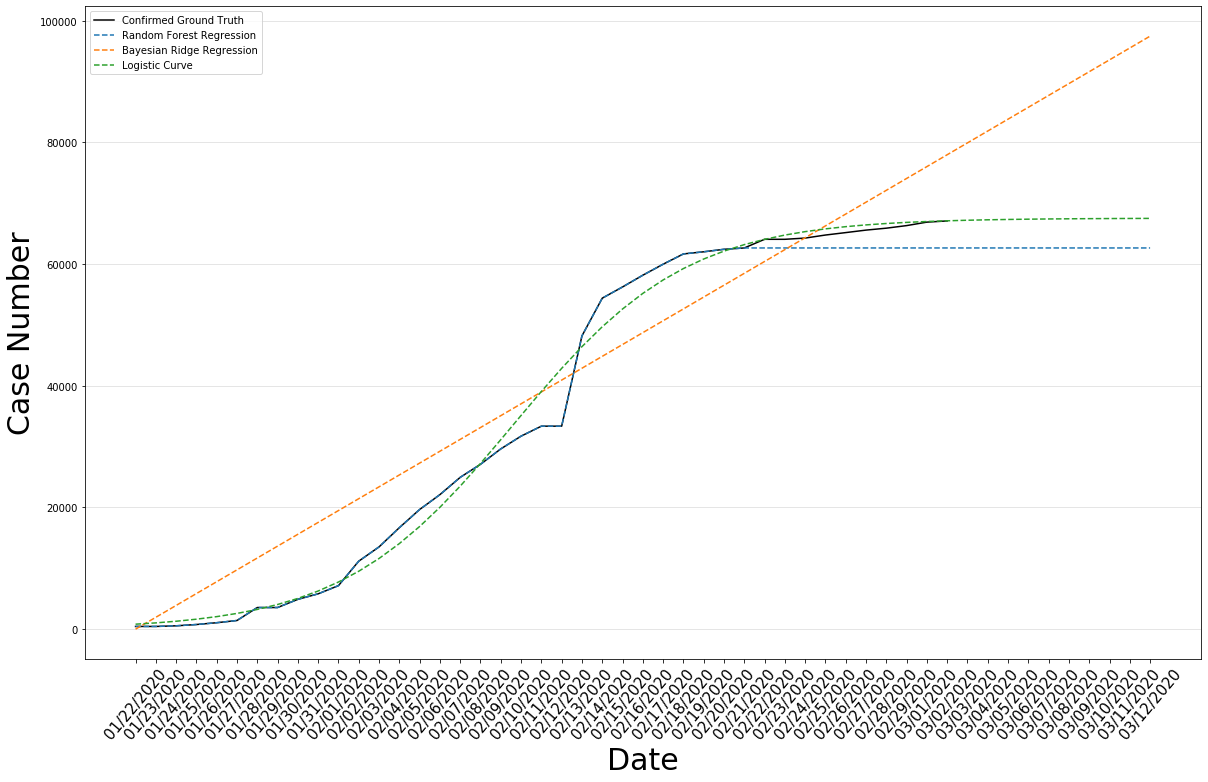

In [40]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, tc,c = 'black')
plt.plot(future_forcast_dates, ensemble_pred, linestyle='dashed')
# plt.plot(future_forcast_dates, knn_pred, linestyle='dashed')
plt.plot(future_forcast_dates, BayesianRidge_pred, linestyle='dashed')
plt.plot(future_forcast_dates, logistic_predict, linestyle='dashed')
plt.xlabel('Date', size=30)
plt.ylabel('Case Number', size=30)
plt.legend(['Confirmed Ground Truth','Random Forest Regression','Bayesian Ridge Regression','Logistic Curve'])
plt.xticks(rotation=50, size=15)
#plt.gca().yaxis.grid(True)
plt.grid(which='major',axis = 'y',alpha=0.4)
plt.show()

In [36]:
avg = []
for i in range(len(future_forcast)):
    avg.append((ensemble_pred[i]+BayesianRidge_pred[i]+logistic_predict[i])/3)

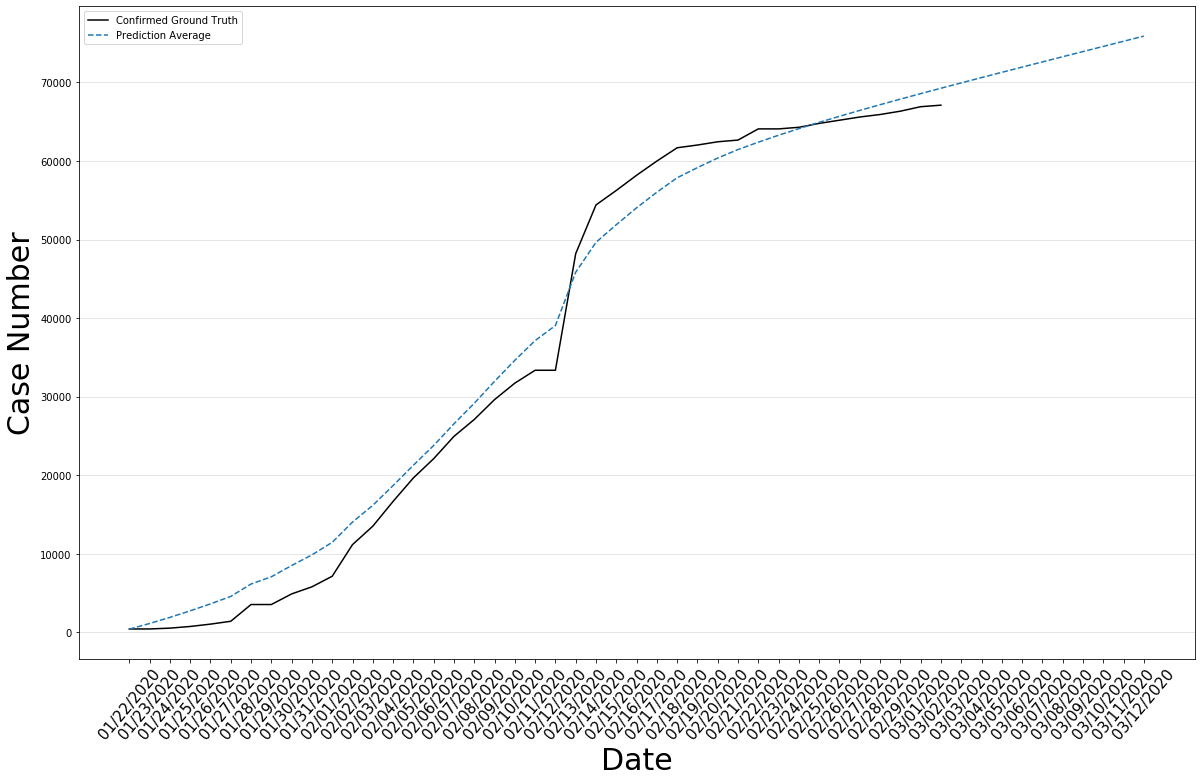

In [41]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, tc,c = 'black')
plt.plot(future_forcast_dates, avg, linestyle='dashed')
plt.xlabel('Date', size=30)
plt.ylabel('Case Number', size=30)
plt.legend(['Confirmed Ground Truth','Prediction Average'])
plt.xticks(rotation=50, size=15)
#plt.gca().yaxis.grid(True)
plt.grid(which='major',axis = 'y',alpha=0.4)
plt.show()